0. Перевести изображение в полутоновое.

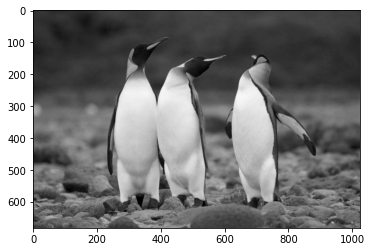

In [2]:
import numpy as np
from PIL import Image, ImageDraw
from pylab import *
import matplotlib.pyplot as plt
import math

image = np.array(Image.open("2.jpg").convert('RGB'))
img = image.copy()
#перевести изображение в полутоновое
for i in range(img.shape[0]):
    for j in range(img.shape[1]):
        #sum = numpyimg[i,j,0] * 0.299 + numpyimg[i,j,1] * 0.587 + numpyimg[i,j,2] * 0.114
        #temp[i][j] = sum
        
        #sum = numpyimg[i,j,0] + numpyimg[i,j,1] + numpyimg[i,j,2]
        #sum/=3
        #data2[i,j] = [sum, sum, sum]

        sum = (int(img[i, j, 0]) + int(img[i, j, 1]) + int(img[i, j, 2]))/3
        img[i, j] = [sum, sum, sum]

plt.imshow(img)
plt.show()

1. Размыть изображение фильтром Гаусса с небольшой дисперсией.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


49


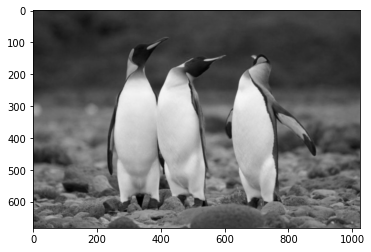

In [4]:
sigma = 1.3
filter = np.zeros((3,3), dtype=np.float)
p=1 #кол-во нулей
for i in range(-1,2):
  for j in range(-1,2):
    filter[i+p,j+p]=np.exp(-(i**2+j**2)/(2*(sigma**2)))
filter/=(np.sqrt(np.pi*2)*(sigma**2))
filter/=filter.sum()

result2 = img.copy()
print(result2[2,2,2])
for i in range(result2.shape[0]-2):
  for j in range(result2.shape[1]-2):
    for k in range(3):
      result2[1+i,1+j,k]=np.sum(filter * img[i:i+3, j:j+3, k])
result2 = result2.astype(np.uint8)
plt.imshow(result2)

2. Вычислить градиент изображения с помощью фильтра Собеля.

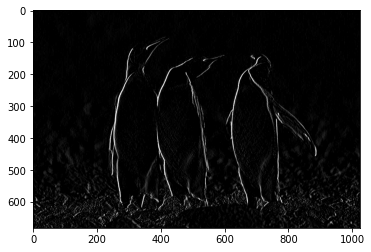

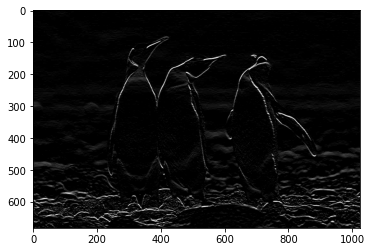

In [5]:
#вычислить градиент изображения с помощью фильтра Собеля
import cv2
sobelx = np.array([[-1,0,1], [-2,0,2], [-1,0,1]])
sobely = np.array([[-1,-2,-1], [0,0,0], [1,2,1]])
imgx = cv2.filter2D(img, -1, sobelx)
imgy = cv2.filter2D(img, -1, sobely)
imshow(imgx)
show()
imshow(imgy)
show()

3. Вычислить магнитуду и направление градиента.

In [6]:
#вычислить магнитуду и направление градиента
import math
sh = np.shape(img)
lxp = zeros((sh[0], sh[1]), np.float64)
lyp = zeros((sh[0], sh[1]), np.float64)
lxp = imgx[:,:,0]
lyp = imgy[:,:,0]
magn = zeros((sh[0], sh[1]), np.float64)
teta = zeros((sh[0], sh[1]), np.float64)
for i in range(sh[0]):
    for j in range(sh[1]):
        magn[i,j] = int((lxp[i,j]**2 + lyp[i,j]**2)**0.5)
        if lxp[i,j]==0:
            teta[i,j] = math.degrees(math.atan(float('inf')))
        else:
            teta[i,j] = math.degrees(math.atan(lyp[i,j]/lxp[i,j]))

4. Округлить направление градиента до 8 направлений (0, 45, 90, 135, 180, 225, 270, 315).

In [7]:
#округлить направление градиента до 8 направлений (0, 45, 90, 135, 180, 225, 270, 315)
grad = [0, 45, 90, 135, 180, 225, 270, 315]
for i in range(sh[0]):
    for j in range(sh[1]):
        teta[i,j] = int(min(grad, key=lambda x:abs(x-teta[i,j])))

5. Применить процедуру подавление немаксимумов вдоль направления градиентов.

In [8]:
#применить процедуру подавление немаксимумов вдоль направления градиентов
for i in range(1, sh[0]-1):
    for j in range(1, sh[1]-1):
        if teta[i,j]==0 or teta[i,j]==180:
            if magn[i,j]<=magn[i-1,j] and magn[i,j]<=magn[i+1,j]:
                magn[i,j] = 0
        if teta[i,j]==90 or teta[i,j]==270:
            if magn[i,j]<=magn[i,j-1] and magn[i,j]<=magn[i,j+1]:
                magn[i,j] = 0
        if teta[i,j]==45 or teta[i,j]==225:
            if magn[i,j]<=magn[i+1,j-1] and magn[i,j]<=magn[i-1,j+1]:
                magn[i,j] = 0
        if teta[i,j]==135 or teta[i,j]==315:
            if magn[i,j]<=magn[i-1,j-1] and magn[i,j]<=magn[i+1,j+1]:
                magn[i,j] = 0

6. Применить процедуру гистерезиса (уточнения границ) на основе 2-х границ. Пиксели, для которых магнитуда градиента больше верхнего порога объявляются границами. Пиксели, для которых магнитуда меньше нижнего порога, объявляются фоном. Пиксели, для которых магнитуда градиента лежит между порогами, проверяются на соседство с пикселем границы.

In [9]:
#применить процедуру гистерезиса (уточнения границ) на основе 2-х границ
T_low = 100
T_high = 200
is_checked = np.zeros((sh[0], sh[1]), dtype=bool)#все false
checked = np.ones((sh[0], sh[1]), dtype=bool)
is_border = np.zeros((sh[0], sh[1]), dtype=bool)#все false
def p(i,j):
    if i in range(0,sh[0]) and j in range(0,sh[1]):
        return True
    else:
        return False
def check_pixel(i, j):
    if is_checked[i,j]==False:
        is_checked[i,j] = True
        if magn[i,j]>T_high:
            is_border[i,j] = True
            if p(i+1,j) and magn[i+1,j]>T_low:
                is_border[i+1,j] = True
                check_pixel(i+1,j)
            if p(i-1,j) and magn[i-1,j]>T_low:
                is_border[i-1,j] = True
                check_pixel(i-1,j)
            if p(i,j+1) and magn[i,j+1]>T_low:
                is_border[i,j+1] = True
                check_pixel(i,j+1)
            if p(i,j-1) and magn[i,j-1]>T_low:
                is_border[i,j-1] = True
                check_pixel(i,j-1)
            if p(i+1,j+1) and magn[i+1,j+1]>T_low:
                is_border[i+1,j+1] = True
                check_pixel(i+1,j+1)
            if p(i-1,j+1) and magn[i-1,j+1]>T_low:
                is_border[i-1,j+1] = True
                check_pixel(i-1,j+1)
            if p(i+1,j-1) and magn[i+1,j-1]>T_low:
                is_border[i+1,j-1] = True
                check_pixel(i+1,j-1)
            if p(i-1,j-1) and magn[i-1,j-1]>T_low:
                is_border[i-1,j-1] = True
                check_pixel(i-1,j-1)
for i in range(sh[0]):
    for j in range(sh[1]):
        check_pixel(i, j)

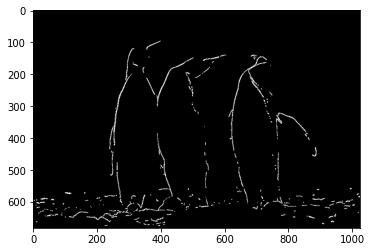

In [10]:
#выводим картинку с границами
for i in range(sh[0]):
    for j in range(sh[1]):
        if is_border[i,j]==True:
            img[i][j][:]=255
        else:
            img[i][j][:]=0
imshow(img)
show()